* __DCC163-2021.1-A - UFJF__
* __Alexandre Vieira Pereira Pacelli - 201865502B__
* __Davi Magalhães Pereira - 201865558C__

# Otimização de portfólio de investimentos

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from docplex.mp.model import Model
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
from re import sub
from decimal import Decimal
import sys
import docplex

## 1. Modelagem

### 1.1. Variáveis

Como variáveis do modelo temos todos os ativos pertencentes à carteira de investimentos do investidor.

Sendo x[i], para todo e qualquer ativo, a porcentagem da carteira a ser investida no mesmo de acordo com a resposta do modelo (seguindo restrições e funcão objetivo)

### 1.2. Restrições

Restrições Solicitadas pelo Investidor:

* Ativos RENDA FIXA == 15% do total investido
* Ativos FUNDOS IMOBILIÁRIOS == 15% do total investido
* Ativos GOLD11, HASH11, BIAU39 == 5% do total investido
* Ativos DEMAIS AÇÕES == 65% do total investido
* TODOS os ATIVOS devem possuir um investimento >= 1% do total investido
* TODOS os ATIVOS devem possuir um investimento <= 15% do total investido
* Soma de todos os investimentos == 100%


Restrições Gerais presentes em todos os modelos testados para o trabalho:

* TODOS os ATIVOS devem possuir um investimento >= 0.5% do total investido
* TODOS os ATIVOS devem possuir um investimento <= 15% do total investido
* Soma de todos os investimentos == 100%
* O RETORNO TOTAL do investimento >= 8% _OU_ A VARIÂNCIA TOTAL do investimento <= 60%


#### Em 2.2.1. Modelo mantendo todas as restrições solicitadas pelo investidor
Neste modelo nós mantivemos as retrições solicitadas pelo investidor.

##### Objetivo - Minimizar Variância

Porcentagem em fundos imobiliários == 0.15<br>
Porcentagem em renda fixa == 0.15<br>
Porcentagem em GOLD11, HASH11 e BIAU39 == 0.05<br>
Porcentagem no restante dos ativos == 0.65<br>
Valor mínimo em cada ação >= 0.005<br>
Valor máximo em cada ação <= 0.15<br>
Soma das váriaveis == 1<br>
Retorno mínimo >= 8<br>

##### Objetivo - Maximizar Retorno

Porcentagem em fundos imobiliários == 0.15<br>
Porcentagem em renda fixa == 0.15<br>
Porcentagem em GOLD11, HASH11 e BIAU39 == 0.05<br>
Porcentagem no restante dos ativos == 0.65<br>
Valor mínimo em cada ação >= 0.005<br>
Valor máximo em cada ação <= 0.15<br>
Soma das váriaveis == 1<br>
Variância máxima <= 60<br>


#### Em 2.2.2. Modelo removendo algumas restrições entre ativos de renda variável
Neste modelo, removemos algumas restrições entre ativos de renda variável e mantivemos as restrições de rendas fixas separadas dos de renda variável, pois esses não devem ser comparados.

##### Objetivo - Minimizar Variância

Porcentagem em renda fixa == 0.15<br>
Porcentagem em renda variável == 0.85<br>
Valor mínimo em cada ação >= 0.005<br>
Valor máximo em cada ação <= 0.15<br>
Soma das váriaveis == 1<br>
Retorno mínimo >= 8<br>

##### Objetivo - Maximizar Retorno

Porcentagem em renda fixa == 0.15<br>
Porcentagem em renda variável == 0.85<br>
Valor mínimo em cada ação >= 0.005<br>
Valor máximo em cada ação <= 0.15<br>
Soma das váriaveis == 1<br>
Variância máxima <= 60<br>

#### Em 2.2.3. Modelo removendo algumas restrições e utilizando faixas de restrições
Neste deixamos o modelo mais livre, ao invés de usar as restrições de igualdades anteriormente propostas demos uma margem para essas.

##### Objetivo - Minimizar Variância

Porcentagem em renda fixa >= 0.1<br>
Porcentagem em renda fixa <= 0.3<br>
Porcentagem em renda variável >= 0.7<br>
Porcentagem em renda variável <= 0.9<br>
Valor mínimo em cada ação >= 0.005<br>
Valor máximo em cada ação <= 0.15<br>
Soma das váriaveis == 1<br>
Retorno mínimo >= 8<br>

##### Objetivo - Maximizar Retorno

Porcentagem em renda fixa >= 0.1<br>
Porcentagem em renda fixa <= 0.3<br>
Porcentagem em renda variável >= 0.7<br>
Porcentagem em renda variável <= 0.9<br>
Valor mínimo em cada ação >= 0.005<br>
Valor máximo em cada ação <= 0.15<br>
Soma das váriaveis == 1<br>
Variância máxima <= 60<br>

#### Em 2.2.4. Modelo mais livre
E, por fim, deixamos o modelo ainda mais livre. Removemos todas restrições impostas aos ativos, exigindo somente que seja alocado uma porcetagem mínima e máxima em cada um.

##### Objetivo - Minimizar Variância

Valor mínimo em cada ação >= 0.005<br>
Valor máximo em cada ação <= 0.15<br>
Soma das váriaveis == 1<br>
Retorno mínimo >= 8<br>

##### Objetivo - Maximizar Retorno

Valor mínimo em cada ação >= 0.005<br>
Valor máximo em cada ação <= 0.15<br>
Soma das váriaveis == 1<br>
Variância máxima <= 60<br>

### 1.3. Função objetivo

Como Função Objetivo, o investidor despertou interesse em descobrir os ativos de MAIOR RETORNO e de MENOR VARIÂNCIA em sua carteira de investimentos.

Portanto, elaboramos as seguintes Funções Objetivo para os dois interesses acima, onde:
* 'i' = Cada Ativo da carteira de investimentos
* 'r' = Retorno em % de cada ativo desde sua compra
* 'v' = Variância de cada ativo desde sua compra

\begin{equation}
z_{min} =\sum_{i=1}^{n} \mbox{v}_i
\end{equation}

\begin{equation}
z_{max} =\sum_{i=1}^{n} \mbox{r}_i
\end{equation}

## 2. Implementação

### 2.1. Coleta de Dados

Realizamos alguns testes com a API de dados do Yahoo e percebemos que algumas ações e rendas fixas possuíam dados faltantes ou inexistentes, então baixamos essas e coletamos os dados manualmente.

In [2]:
variables = ['XPCI11.SA KNRI11.SA XINA11 VIVT3 TRPL4 TRIS3 TGAR11 TEND3 TAEE11 SULA11 RAIZ4 OIBR3 MXRF11 JHSF3 IVVB11 HASH11 GOLD11 GOAU4 GGBR4 FESA4 EGIE3 DIRR3 CYRE3 CSAN3 COGN3 BRPR3 BRML3 BOVA11 BIAU39 BABA34 AURA33 ALUP11 ALSO3']

# par = ['-22.08 -7.45 -8.94 -23.36 +0.29 -19.57 +24.53 -12.05 -3.51 -38.0 -0.8 +7.34 +9.53 -5.79 -3.85 +1.41 +2.38 +16.51 -7.68 -6.52 -17.04 +4.83 -14.84 -3.45 +22.01 +4.70 -1.77 -27.99 +14.35 -5.53 +8.66']

In [3]:
return_dict = {'IPCA': -7.18, 'Selic': 0, 'Prefixado': 0, 'KNRI11.SA': 0, 'XPCI11.SA': 0, 'XINA11.SA': -22.08, 'VIVT3.SA': -7.45, 'TRPL4.SA': -8.94, 'TRIS3.SA': -23.36, 'TGAR11.SA': 0.29, 'TEND3.SA': -19.57, 'TAEE11.SA': 24.53, 'SULA11.SA': -12.05, 'RAIZ4.SA': -3.51, 'OIBR3.SA': -38.0, 'MXRF11.SA': -0.8, 'JHSF3.SA': 7.34, 'IVVB11.SA': 9.53, 'HASH11.SA': -5.79, 'GOLD11.SA': -3.85, 'GOAU4.SA': 1.41, 'GGBR4.SA': 2.38, 'FESA4.SA': 16.51, 'EGIE3.SA': -7.68, 'DIRR3.SA': -6.52, 'CYRE3.SA': -17.04, 'CSAN3.SA': 4.83, 'COGN3.SA': -14.84, 'BRPR3.SA': -3.45, 'BRML3.SA': 22.01, 'BOVA11.SA': 4.70, 'BIAU39.SA': -1.77, 'BABA34.SA': -27.99, 'AURA33.SA': 14.35, 'ALUP11.SA': -5.53, 'ALSO3.SA':8.66}
return_dict

{'IPCA': -7.18,
 'Selic': 0,
 'Prefixado': 0,
 'KNRI11.SA': 0,
 'XPCI11.SA': 0,
 'XINA11.SA': -22.08,
 'VIVT3.SA': -7.45,
 'TRPL4.SA': -8.94,
 'TRIS3.SA': -23.36,
 'TGAR11.SA': 0.29,
 'TEND3.SA': -19.57,
 'TAEE11.SA': 24.53,
 'SULA11.SA': -12.05,
 'RAIZ4.SA': -3.51,
 'OIBR3.SA': -38.0,
 'MXRF11.SA': -0.8,
 'JHSF3.SA': 7.34,
 'IVVB11.SA': 9.53,
 'HASH11.SA': -5.79,
 'GOLD11.SA': -3.85,
 'GOAU4.SA': 1.41,
 'GGBR4.SA': 2.38,
 'FESA4.SA': 16.51,
 'EGIE3.SA': -7.68,
 'DIRR3.SA': -6.52,
 'CYRE3.SA': -17.04,
 'CSAN3.SA': 4.83,
 'COGN3.SA': -14.84,
 'BRPR3.SA': -3.45,
 'BRML3.SA': 22.01,
 'BOVA11.SA': 4.7,
 'BIAU39.SA': -1.77,
 'BABA34.SA': -27.99,
 'AURA33.SA': 14.35,
 'ALUP11.SA': -5.53,
 'ALSO3.SA': 8.66}

In [4]:
selic = pd.read_csv('data/Selic2027.csv')
selic.drop(['Data', 'Var%', 'Abertura', 'Máxima', 'Mínima'], axis=1, inplace=True)
selic.head()

,Último
0,"10.785,177"
1,"10.783,554"
2,"10.781,931"
3,"10.782,094"
4,"10.780,843"


In [5]:
selic['Último'] = selic['Último'].apply(lambda x: x.replace(".", "").replace(",",".")).astype(float)
selic.head()

,Último
0,10785.177
1,10783.554
2,10781.931
3,10782.094
4,10780.843


In [6]:
var_dict = {'Selic': selic['Último'].var()}
var_dict

{'Selic': 7605.365255462518}

In [7]:
prefixado = pd.read_csv('data/Prefixado2026.csv')
prefixado.drop(['Data', 'Var%', 'Abertura', 'Máxima', 'Mínima'], axis=1, inplace=True)
prefixado['Último'] = prefixado['Último'].apply(lambda x: x.replace(".", "").replace(",",".")).astype(float)
prefixado.head()

,Último
0,656.53
1,660.99
2,666.85
3,671.42
4,668.50


In [8]:
var_dict['Prefixado'] = prefixado['Último'].var()
var_dict

{'Selic': 7605.365255462518, 'Prefixado': 271.49614009511976}

In [9]:
ipca = pd.read_csv('data/IMBB11.csv', sep='\t')
ipca.drop(['Data', 'Variação', 'Abertura', 'Máxima', 'Mínima', 'Variação (%)', 'Volume'], axis=1, inplace=True)
ipca['Fechamento'] = ipca['Fechamento'].apply(lambda x: x.replace(".", "").replace(",",".")).astype(float)
ipca.rename(columns = {'Fechamento': 'Último'},inplace=True)
ipca.head()

,Último
0,103.65
1,103.25
2,103.65
3,104.30
4,104.35


In [10]:
var_dict['IPCA'] = ipca['Último'].var()
var_dict

{'Selic': 7605.365255462518,
 'Prefixado': 271.49614009511976,
 'IPCA': 5.2457444321145195}

In [11]:
hash11 = pd.read_csv('data/HASH11.csv')
hash11.drop(['Data', 'Var%', 'Abertura', 'Máxima', 'Mínima', 'Vol.'], axis=1, inplace=True)
hash11['Último'] = hash11['Último'].apply(lambda x: x.replace(".", "").replace(",",".")).astype(float)
hash11.head()

,Último
0,43.06
1,43.15
2,44.30
3,45.00
4,42.72


In [12]:
var_dict['HASH11.SA'] = hash11['Último'].var()
var_dict

{'Selic': 7605.365255462518,
 'Prefixado': 271.49614009511976,
 'IPCA': 5.2457444321145195,
 'HASH11.SA': 74.32406074367088}

In [13]:
tgar11 = pd.read_csv('data/TGAR11.csv')
tgar11.drop(['Data', 'Var%', 'Abertura', 'Máxima', 'Mínima', 'Vol.'], axis=1, inplace=True)
tgar11['Último'] = tgar11['Último'].apply(lambda x: x.replace(".", "").replace(",",".")).astype(float)
tgar11.head()

,Último
0,123.04
1,122.79
2,124.12
3,125.00
4,124.00


In [14]:
var_dict['TGAR11.SA'] = tgar11['Último'].var()
var_dict

{'Selic': 7605.365255462518,
 'Prefixado': 271.49614009511976,
 'IPCA': 5.2457444321145195,
 'HASH11.SA': 74.32406074367088,
 'TGAR11.SA': 17.432172175786853}

In [15]:
biau39 = pd.read_csv('data/BIAU39.csv')
biau39.drop(['Data', 'Var%', 'Abertura', 'Máxima', 'Mínima', 'Vol.'], axis=1, inplace=True)
biau39['Último'] = biau39['Último'].apply(lambda x: x.replace(".", "").replace(",",".")).astype(float)
biau39.head()

,Último
0,45.50
1,44.65
2,44.88
3,44.35
4,43.77


In [16]:
var_dict['BIAU39.SA'] = biau39['Último'].var()
var_dict

{'Selic': 7605.365255462518,
 'Prefixado': 271.49614009511976,
 'IPCA': 5.2457444321145195,
 'HASH11.SA': 74.32406074367088,
 'TGAR11.SA': 17.432172175786853,
 'BIAU39.SA': 2.374279376623375}

In [17]:
gold11 = pd.read_csv('data/GOLD11.csv')
gold11.drop(['Data', 'Var%', 'Abertura', 'Máxima', 'Mínima', 'Vol.'], axis=1, inplace=True)
gold11['Último'] = gold11['Último'].apply(lambda x: x.replace(".", "").replace(",",".")).astype(float)
gold11.head()

,Último
0,10.22
1,10.06
2,10.10
3,9.98
4,9.85


In [18]:
var_dict['GOLD11.SA'] = gold11['Último'].var()
var_dict

{'Selic': 7605.365255462518,
 'Prefixado': 271.49614009511976,
 'IPCA': 5.2457444321145195,
 'HASH11.SA': 74.32406074367088,
 'TGAR11.SA': 17.432172175786853,
 'BIAU39.SA': 2.374279376623375,
 'GOLD11.SA': 0.12897262139466956}

In [19]:
xina11 = pd.read_csv('data/XINA11.csv')
xina11.drop(['Data', 'Var%', 'Abertura', 'Máxima', 'Mínima', 'Vol.'], axis=1, inplace=True)
xina11['Último'] = xina11['Último'].apply(lambda x: x.replace(".", "").replace(",",".")).astype(float)
xina11.head()

,Último
0,8.96
1,8.74
2,8.98
3,9.11
4,9.16


In [20]:
var_dict['XINA11.SA'] = xina11['Último'].var()
var_dict

{'Selic': 7605.365255462518,
 'Prefixado': 271.49614009511976,
 'IPCA': 5.2457444321145195,
 'HASH11.SA': 74.32406074367088,
 'TGAR11.SA': 17.432172175786853,
 'BIAU39.SA': 2.374279376623375,
 'GOLD11.SA': 0.12897262139466956,
 'XINA11.SA': 1.0428390993788819}

Coletados os dados faltantes podemos obter o restante pela API.

In [21]:
df = yf.download(tickers="KNRI11.SA XPCI11.SA VIVT3.SA TRPL4.SA TRIS3.SA TEND3.SA TAEE11.SA SULA11.SA RAIZ4.SA OIBR3.SA MXRF11.SA JHSF3.SA IVVB11.SA GOAU4.SA GGBR4.SA FESA4.SA EGIE3.SA DIRR3.SA CYRE3.SA CSAN3.SA COGN3.SA BRPR3.SA BRML3.SA BOVA11.SA BABA34.SA AURA33.SA ALUP11.SA ALSO3.SA",
                 period='1y')#start="2018-01-01", end="2021-08-11")

[*********************100%***********************]  28 of 28 completed


In [22]:
df.head()

Adj Close                                                       \
             ALSO3.SA  ALUP11.SA  AURA33.SA  BABA34.SA  BOVA11.SA BRML3.SA   
Date                                                                         
2020-09-15  27.298727  22.873545  60.859756  52.439999  96.459999     9.77   
2020-09-16  27.953182  23.067225  60.719746  52.294998  95.910004     9.98   
2020-09-17  27.229313  23.076908  60.477051  52.489285  96.370003     9.79   
2020-09-18  26.326958  22.815441  61.317142  52.538216  94.639999     9.40   
2020-09-21  25.503931  23.144695  61.559830  52.782143  93.400002     9.13   

                                                     ...    Volume             \
            BRPR3.SA COGN3.SA   CSAN3.SA   CYRE3.SA  ... MXRF11.SA   OIBR3.SA   
Date                                                 ...                        
2020-09-15  9.547308     5.80  18.708744  22.264324  ...    483390  120170500   
2020-09-16  9.674476     5.83  18.587660  21.854721  ...    547692  107127900   
2020-09-17  9.508180     5.77  18.684032  21.508831  ...    594993  115015200   
2020-09-18  9.253846     5.53  18.298542  20.953590  ...    703714  121451000   
2020-09-21  8.999512     5.56  18.128035  20.762440  ...    697246  136369500   

                                                                             \
           RAIZ4.SA SULA11.SA TAEE11.SA TEND3.SA TRIS3.SA TRPL4.SA VIVT3.SA   
Date                                                                          
2020-09-15      NaN   2515065   2622800  1211900   869500   770200    88700   
2020-09-16      NaN   2056759   2195500   811100  3396100  1175900   146100   
2020-09-17      NaN   1731018   2300700  1372200  1644800   854900   115900   
2020-09-18      NaN   2177548   2269200  2358800  2661900  1682500   141600   
2020-09-21      NaN   2784949   3346800  1056100  1939500  2049800   115700   

                      
           XPCI11.SA  
Date                  
2020-09-15     12974  
2020-09-16     16583  
2020-09-17      7038  
2020-09-18     19657  
2020-09-21     10740  

[5 rows x 168 columns]

In [23]:
df_close = df['Close']
df_close.head()

,ALSO3.SA,ALUP11.SA,AURA33.SA,BABA34.SA,BOVA11.SA,BRML3.SA,BRPR3.SA,COGN3.SA,CSAN3.SA,CYRE3.SA,...,MXRF11.SA,OIBR3.SA,RAIZ4.SA,SULA11.SA,TAEE11.SA,TEND3.SA,TRIS3.SA,TRPL4.SA,VIVT3.SA,XPCI11.SA
Date,,,,,,,,,,,,,,,,,,,,,
2020-09-15,27.530001,23.620001,65.199997,52.439999,96.459999,9.77,9.76,5.80,18.927500,24.459999,...,10.59,1.81,NaN,38.208035,28.559999,30.610001,11.83,21.100000,48.000000,88.239998
2020-09-16,28.190001,23.820000,65.050003,52.294998,95.910004,9.98,9.89,5.83,18.805000,24.010000,...,10.67,1.82,NaN,38.180267,28.709999,29.889999,12.33,21.120001,47.369999,88.050003
2020-09-17,27.459999,23.830000,64.790001,52.489285,96.370003,9.79,9.72,5.77,18.902500,23.629999,...,10.72,1.84,NaN,38.189522,28.620001,29.500000,12.08,21.170000,47.500000,88.809998
2020-09-18,26.549999,23.559999,65.690002,52.538216,94.639999,9.40,9.46,5.53,18.512501,23.020000,...,10.74,1.80,NaN,37.152870,28.280001,28.600000,11.64,21.309999,47.090000,89.459999
2020-09-21,25.719999,23.900000,65.949997,52.782143,93.400002,9.13,9.20,5.56,18.340000,22.809999,...,10.72,1.72,NaN,37.930359,28.330000,27.790001,11.15,21.629999,46.700001,89.580002


In [24]:
var_dict

{'Selic': 7605.365255462518,
 'Prefixado': 271.49614009511976,
 'IPCA': 5.2457444321145195,
 'HASH11.SA': 74.32406074367088,
 'TGAR11.SA': 17.432172175786853,
 'BIAU39.SA': 2.374279376623375,
 'GOLD11.SA': 0.12897262139466956,
 'XINA11.SA': 1.0428390993788819}

In [25]:
for column in df_close.columns:
    var_dict[column] = df_close[column].var()

E por fim temos os dois dicionários para formar a função objetivo de um tipo de carteira que foi solicitado pelo investidor. O mesmo nos explicou que gostaria de aplicar mais dinheiro em ações/fundos/rendas fixas menos voláteis e ao mesmo tempo, levar em consideração quanto cada investimento o retornou desde sua compra.

In [26]:
var_dict

{'Selic': 7605.365255462518,
 'Prefixado': 271.49614009511976,
 'IPCA': 5.2457444321145195,
 'HASH11.SA': 74.32406074367088,
 'TGAR11.SA': 17.432172175786853,
 'BIAU39.SA': 2.374279376623375,
 'GOLD11.SA': 0.12897262139466956,
 'XINA11.SA': 1.0428390993788819,
 'ALSO3.SA': 4.36896747207787,
 'ALUP11.SA': 1.7007738498640963,
 'AURA33.SA': 26.776399023259668,
 'BABA34.SA': 65.51771640906016,
 'BOVA11.SA': 83.49938798829692,
 'BRML3.SA': 0.6631038812956846,
 'BRPR3.SA': 0.4034537118220449,
 'COGN3.SA': 0.39583910374051745,
 'CSAN3.SA': 7.367294588012832,
 'CYRE3.SA': 8.199557423967647,
 'DIRR3.SA': 0.7191986951475353,
 'EGIE3.SA': 4.311363585807714,
 'FESA4.SA': 160.91942713847945,
 'GGBR4.SA': 18.58427404078702,
 'GOAU4.SA': 3.7714179619126638,
 'IVVB11.SA': 353.28099110994503,
 'JHSF3.SA': 0.20356866592470116,
 'KNRI11.SA': 97.52261246881972,
 'MXRF11.SA': 0.05553427779612003,
 'OIBR3.SA': 0.13546025590840305,
 'RAIZ4.SA': 0.05049925813488985,
 'SULA11.SA': 14.81140908560355,
 'TAEE11.S

In [27]:
return_dict

{'IPCA': -7.18,
 'Selic': 0,
 'Prefixado': 0,
 'KNRI11.SA': 0,
 'XPCI11.SA': 0,
 'XINA11.SA': -22.08,
 'VIVT3.SA': -7.45,
 'TRPL4.SA': -8.94,
 'TRIS3.SA': -23.36,
 'TGAR11.SA': 0.29,
 'TEND3.SA': -19.57,
 'TAEE11.SA': 24.53,
 'SULA11.SA': -12.05,
 'RAIZ4.SA': -3.51,
 'OIBR3.SA': -38.0,
 'MXRF11.SA': -0.8,
 'JHSF3.SA': 7.34,
 'IVVB11.SA': 9.53,
 'HASH11.SA': -5.79,
 'GOLD11.SA': -3.85,
 'GOAU4.SA': 1.41,
 'GGBR4.SA': 2.38,
 'FESA4.SA': 16.51,
 'EGIE3.SA': -7.68,
 'DIRR3.SA': -6.52,
 'CYRE3.SA': -17.04,
 'CSAN3.SA': 4.83,
 'COGN3.SA': -14.84,
 'BRPR3.SA': -3.45,
 'BRML3.SA': 22.01,
 'BOVA11.SA': 4.7,
 'BIAU39.SA': -1.77,
 'BABA34.SA': -27.99,
 'AURA33.SA': 14.35,
 'ALUP11.SA': -5.53,
 'ALSO3.SA': 8.66}

### 2.2. Implementação do Modelo

Com os dados de variância e retorno obtidos, podemos agora otimizar o portfólio.

In [28]:
fi = ['XPCI11.SA', 'KNRI11.SA', 'MXRF11.SA', 'TGAR11.SA']
rf = ['IPCA', 'Selic', 'Prefixado']
ghb = ['GOLD11.SA', 'HASH11.SA', 'BIAU39.SA']

In [29]:
keys = list(return_dict.keys())
r = [x for x in keys if x not in (fi + rf + ghb)]

In [30]:
a = [x for x in keys if x not in (rf)]

#### 2.2.1. Modelo mantendo todas as restrições solicitadas

* Minimizando a variância e com retorno mínimo de 8%

In [31]:
model = Model()
x = model.continuous_var_dict(keys, name='invs')

In [32]:
model.minimize(model.sum(x[i] * var_dict[i] for i in x.keys()))

In [33]:
model.add_constraint(model.sum(x[i] for i in fi) == 0.15)
model.add_constraint(model.sum(x[i] for i in rf) == 0.15)
model.add_constraint(model.sum(x[i] for i in ghb) == 0.05)
model.add_constraint(model.sum(x[i] for i in r) == 0.65)
model.add_constraints(x[i] >= 0.005 for i in keys)
model.add_constraints(x[i] <= 0.15 for i in keys)
model.add_constraint(model.sum(x[i] for i in keys) == 1)
model.add_constraint(model.sum(x[i] * return_dict[i] for i in keys) >= 8)

docplex.mp.LinearConstraint[](-7.180invs_IPCA-22.080invs_XINA11.SA-7.450invs_VIVT3.SA-8.940invs_TRPL4.SA-23.360invs_TRIS3.SA+0.290invs_TGAR11.SA-19.570invs_TEND3.SA+24.530invs_TAEE11.SA-12.050invs_SULA11.SA-3.510invs_RAIZ4.SA-38invs_OIBR3.SA-0.800invs_MXRF11.SA+7.340invs_JHSF3.SA+9.530invs_IVVB11.SA-5.790invs_HASH11.SA-3.850invs_GOLD11.SA+1.410invs_GOAU4.SA+2.380invs_GGBR4.SA+16.510invs_FESA4.SA-7.680invs_EGIE3.SA-6.520invs_DIRR3.SA-17.040invs_CYRE3.SA+4.830invs_CSAN3.SA-14.840invs_COGN3.SA-3.450invs_BRPR3.SA+22.010invs_BRML3.SA+4.700invs_BOVA11.SA-1.770invs_BIAU39.SA-27.990invs_BABA34.SA+14.350invs_AURA33.SA-5.530invs_ALUP11.SA+8.660invs_ALSO3.SA,GE,8)

In [34]:
solution = model.solve(log_output=True)

Version identifier: 20.1.0.0 | 2020-11-10 | 9bedb6d68
CPXPARAM_Read_DataCheck                          1
CPXPARAM_RandomSeed                              202001241
Tried aggregator 1 time.
LP Presolve eliminated 73 rows and 2 columns.
Aggregator did 1 substitutions.
Reduced LP has 4 rows, 33 columns, and 64 nonzeros.
Presolve time = 0.00 sec. (0.06 ticks)
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =            46.073855


In [35]:
model.print_solution()

objective: 54.997
  invs_IPCA=0.140
  invs_Selic=0.005
  invs_Prefixado=0.005
  invs_KNRI11.SA=0.005
  invs_XPCI11.SA=0.005
  invs_XINA11.SA=0.005
  invs_VIVT3.SA=0.005
  invs_TRPL4.SA=0.005
  invs_TRIS3.SA=0.005
  invs_TGAR11.SA=0.135
  invs_TEND3.SA=0.005
  invs_TAEE11.SA=0.150
  invs_SULA11.SA=0.005
  invs_RAIZ4.SA=0.005
  invs_OIBR3.SA=0.005
  invs_MXRF11.SA=0.005
  invs_JHSF3.SA=0.005
  invs_IVVB11.SA=0.005
  invs_HASH11.SA=0.005
  invs_GOLD11.SA=0.005
  invs_GOAU4.SA=0.005
  invs_GGBR4.SA=0.005
  invs_FESA4.SA=0.009
  invs_EGIE3.SA=0.005
  invs_DIRR3.SA=0.005
  invs_CYRE3.SA=0.005
  invs_CSAN3.SA=0.005
  invs_COGN3.SA=0.005
  invs_BRPR3.SA=0.005
  invs_BRML3.SA=0.150
  invs_BOVA11.SA=0.005
  invs_BIAU39.SA=0.040
  invs_BABA34.SA=0.005
  invs_AURA33.SA=0.150
  invs_ALUP11.SA=0.005
  invs_ALSO3.SA=0.086


In [36]:
total_return = 0
for i in keys:
    total_return += x[i].solution_value * return_dict[i]

In [37]:
total_rf = 0
for i in rf:
    total_rf += x[i].solution_value

In [38]:
total_a = 0
for i in a:
    total_a += x[i].solution_value

In [39]:
print('Variâcia encontrada pela função objetivo: ', model.objective_value)
print('Retorno total: ', total_return)
print('Total alocado em renda fixa: ', total_rf)
print('Total alocado em renda variável: ', total_a)

Variâcia encontrada pela função objetivo:  54.99747918446086
Retorno total:  7.999999999999997
Total alocado em renda fixa:  0.15
Total alocado em renda variável:  0.8500000000000001


* Maximizando o retorno e com variância máxima de 60

In [40]:
model = Model()
x = model.continuous_var_dict(keys, name='invs')

In [41]:
model.maximize(model.sum(x[i] * return_dict[i] for i in x.keys()))

In [42]:
model.add_constraint(model.sum(x[i] for i in fi) == 0.15)
model.add_constraint(model.sum(x[i] for i in rf) == 0.15)
model.add_constraint(model.sum(x[i] for i in ghb) == 0.05)
model.add_constraint(model.sum(x[i] for i in r) == 0.65)
model.add_constraints(x[i] >= 0.005 for i in keys)
model.add_constraints(x[i] <= 0.15 for i in keys)
model.add_constraint(model.sum(x[i] for i in keys) == 1)
model.add_constraint(model.sum(x[i] * var_dict[i] for i in keys) <= 60)

docplex.mp.LinearConstraint[](5.246invs_IPCA+7605.365invs_Selic+271.496invs_Prefixado+97.523invs_KNRI11.SA+19.419invs_XPCI11.SA+1.043invs_XINA11.SA+2.820invs_VIVT3.SA+3.110invs_TRPL4.SA+1.877invs_TRIS3.SA+17.432invs_TGAR11.SA+9.315invs_TEND3.SA+17.345invs_TAEE11.SA+14.811invs_SULA11.SA+0.050invs_RAIZ4.SA+0.135invs_OIBR3.SA+0.056invs_MXRF11.SA+0.204invs_JHSF3.SA+353.281invs_IVVB11.SA+74.324invs_HASH11.SA+0.129invs_GOLD11.SA+3.771invs_GOAU4.SA+18.584invs_GGBR4.SA+160.919invs_FESA4.SA+4.311invs_EGIE3.SA+0.719invs_DIRR3.SA+8.200invs_CYRE3.SA+7.367invs_CSAN3.SA+0.396invs_COGN3.SA+0.403invs_BRPR3.SA+0.663invs_BRML3.SA+83.499invs_BOVA11.SA+2.374invs_BIAU39.SA+65.518invs_BABA34.SA+26.776invs_AURA33.SA+1.701invs_ALUP11.SA+4.369invs_ALSO3.SA,LE,60)

In [43]:
solution = model.solve(log_output=True)

Version identifier: 20.1.0.0 | 2020-11-10 | 9bedb6d68
CPXPARAM_Read_DataCheck                          1
CPXPARAM_RandomSeed                              202001241
Tried aggregator 1 time.
LP Presolve eliminated 73 rows and 0 columns.
Reduced LP has 5 rows, 36 columns, and 72 nonzeros.
Presolve time = 0.00 sec. (0.05 ticks)
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =             9.733450


In [44]:
model.print_solution()

objective: 8.251
  invs_IPCA=0.140
  invs_Selic=0.005
  invs_Prefixado=0.005
  invs_KNRI11.SA=0.005
  invs_XPCI11.SA=0.005
  invs_XINA11.SA=0.005
  invs_VIVT3.SA=0.005
  invs_TRPL4.SA=0.005
  invs_TRIS3.SA=0.005
  invs_TGAR11.SA=0.135
  invs_TEND3.SA=0.005
  invs_TAEE11.SA=0.150
  invs_SULA11.SA=0.005
  invs_RAIZ4.SA=0.005
  invs_OIBR3.SA=0.005
  invs_MXRF11.SA=0.005
  invs_JHSF3.SA=0.005
  invs_IVVB11.SA=0.005
  invs_HASH11.SA=0.005
  invs_GOLD11.SA=0.005
  invs_GOAU4.SA=0.005
  invs_GGBR4.SA=0.005
  invs_FESA4.SA=0.041
  invs_EGIE3.SA=0.005
  invs_DIRR3.SA=0.005
  invs_CYRE3.SA=0.005
  invs_CSAN3.SA=0.005
  invs_COGN3.SA=0.005
  invs_BRPR3.SA=0.005
  invs_BRML3.SA=0.150
  invs_BOVA11.SA=0.005
  invs_BIAU39.SA=0.040
  invs_BABA34.SA=0.005
  invs_AURA33.SA=0.150
  invs_ALUP11.SA=0.005
  invs_ALSO3.SA=0.054


In [45]:
total_var = 0
for i in keys:
    total_var += x[i].solution_value * var_dict[i]

In [46]:
total_rf = 0
for i in rf:
    total_rf += x[i].solution_value

In [47]:
total_a = 0
for i in a:
    total_a += x[i].solution_value

In [48]:
print('Retorno encontrado pela função objetivo: ', model.objective_value)
print('Variância total: ', total_var)
print('Total alocado em renda fixa: ', total_rf)
print('Total alocado em renda variável: ', total_a)

Retorno encontrado pela função objetivo:  8.250844286792024
Variância total:  59.99999999999998
Total alocado em renda fixa:  0.15
Total alocado em renda variável:  0.85


#### 2.2.2. Modelo removendo algumas restrições entre ativos de renda variável

* Minimizando a variância e com retorno mínimo de 8%

In [49]:
model = Model()
x = model.continuous_var_dict(keys, name='invs')

In [50]:
model.minimize(model.sum(x[i] * var_dict[i] for i in x.keys()))

In [51]:
model.add_constraint(model.sum(x[i] for i in rf) == 0.15)
model.add_constraint(model.sum(x[i] for i in a) == 0.85)
model.add_constraints(x[i] >= 0.005 for i in keys)
model.add_constraints(x[i] <= 0.15 for i in keys)
model.add_constraint(model.sum(x[i] for i in keys) == 1)
model.add_constraint(model.sum(x[i] * return_dict[i] for i in keys) >= 8)

docplex.mp.LinearConstraint[](-7.180invs_IPCA-22.080invs_XINA11.SA-7.450invs_VIVT3.SA-8.940invs_TRPL4.SA-23.360invs_TRIS3.SA+0.290invs_TGAR11.SA-19.570invs_TEND3.SA+24.530invs_TAEE11.SA-12.050invs_SULA11.SA-3.510invs_RAIZ4.SA-38invs_OIBR3.SA-0.800invs_MXRF11.SA+7.340invs_JHSF3.SA+9.530invs_IVVB11.SA-5.790invs_HASH11.SA-3.850invs_GOLD11.SA+1.410invs_GOAU4.SA+2.380invs_GGBR4.SA+16.510invs_FESA4.SA-7.680invs_EGIE3.SA-6.520invs_DIRR3.SA-17.040invs_CYRE3.SA+4.830invs_CSAN3.SA-14.840invs_COGN3.SA-3.450invs_BRPR3.SA+22.010invs_BRML3.SA+4.700invs_BOVA11.SA-1.770invs_BIAU39.SA-27.990invs_BABA34.SA+14.350invs_AURA33.SA-5.530invs_ALUP11.SA+8.660invs_ALSO3.SA,GE,8)

In [52]:
solution = model.solve(log_output=True)

Version identifier: 20.1.0.0 | 2020-11-10 | 9bedb6d68
CPXPARAM_Read_DataCheck                          1
CPXPARAM_RandomSeed                              202001241
Tried aggregator 1 time.
LP Presolve eliminated 73 rows and 1 columns.
Aggregator did 1 substitutions.
Reduced LP has 2 rows, 34 columns, and 65 nonzeros.
Presolve time = 0.00 sec. (0.05 ticks)
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =            47.748748


In [53]:
model.print_solution()

objective: 49.176
  invs_IPCA=0.140
  invs_Selic=0.005
  invs_Prefixado=0.005
  invs_KNRI11.SA=0.005
  invs_XPCI11.SA=0.005
  invs_XINA11.SA=0.005
  invs_VIVT3.SA=0.005
  invs_TRPL4.SA=0.005
  invs_TRIS3.SA=0.005
  invs_TGAR11.SA=0.005
  invs_TEND3.SA=0.005
  invs_TAEE11.SA=0.150
  invs_SULA11.SA=0.005
  invs_RAIZ4.SA=0.005
  invs_OIBR3.SA=0.005
  invs_MXRF11.SA=0.005
  invs_JHSF3.SA=0.150
  invs_IVVB11.SA=0.005
  invs_HASH11.SA=0.005
  invs_GOLD11.SA=0.005
  invs_GOAU4.SA=0.005
  invs_GGBR4.SA=0.005
  invs_FESA4.SA=0.005
  invs_EGIE3.SA=0.005
  invs_DIRR3.SA=0.005
  invs_CYRE3.SA=0.005
  invs_CSAN3.SA=0.110
  invs_COGN3.SA=0.005
  invs_BRPR3.SA=0.005
  invs_BRML3.SA=0.150
  invs_BOVA11.SA=0.005
  invs_BIAU39.SA=0.005
  invs_BABA34.SA=0.005
  invs_AURA33.SA=0.005
  invs_ALUP11.SA=0.005
  invs_ALSO3.SA=0.150


In [54]:
total_return = 0
for i in keys:
    total_return += x[i].solution_value * return_dict[i]

In [55]:
total_rf = 0
for i in rf:
    total_rf += x[i].solution_value

In [56]:
total_a = 0
for i in a:
    total_a += x[i].solution_value

In [57]:
print('Variâcia encontrada pela função objetivo: ', model.objective_value)
print('Retorno total: ', total_return)
print('Total alocado em renda fixa: ', total_rf)
print('Total alocado em renda variável: ', total_a)

Variâcia encontrada pela função objetivo:  49.176310588122426
Retorno total:  7.999999999999998
Total alocado em renda fixa:  0.15
Total alocado em renda variável:  0.85


* Maximizando o retorno e com variância máxima de 60

In [58]:
model = Model()
x = model.continuous_var_dict(keys, name='invs')

In [59]:
model.maximize(model.sum(x[i] * return_dict[i] for i in x.keys()))

In [60]:
model.add_constraint(model.sum(x[i] for i in rf) == 0.15)
model.add_constraint(model.sum(x[i] for i in a) == 0.85)
model.add_constraints(x[i] >= 0.005 for i in keys)
model.add_constraints(x[i] <= 0.15 for i in keys)
model.add_constraint(model.sum(x[i] for i in keys) == 1)
model.add_constraint(model.sum(x[i] * var_dict[i] for i in keys) <= 60)

docplex.mp.LinearConstraint[](5.246invs_IPCA+7605.365invs_Selic+271.496invs_Prefixado+97.523invs_KNRI11.SA+19.419invs_XPCI11.SA+1.043invs_XINA11.SA+2.820invs_VIVT3.SA+3.110invs_TRPL4.SA+1.877invs_TRIS3.SA+17.432invs_TGAR11.SA+9.315invs_TEND3.SA+17.345invs_TAEE11.SA+14.811invs_SULA11.SA+0.050invs_RAIZ4.SA+0.135invs_OIBR3.SA+0.056invs_MXRF11.SA+0.204invs_JHSF3.SA+353.281invs_IVVB11.SA+74.324invs_HASH11.SA+0.129invs_GOLD11.SA+3.771invs_GOAU4.SA+18.584invs_GGBR4.SA+160.919invs_FESA4.SA+4.311invs_EGIE3.SA+0.719invs_DIRR3.SA+8.200invs_CYRE3.SA+7.367invs_CSAN3.SA+0.396invs_COGN3.SA+0.403invs_BRPR3.SA+0.663invs_BRML3.SA+83.499invs_BOVA11.SA+2.374invs_BIAU39.SA+65.518invs_BABA34.SA+26.776invs_AURA33.SA+1.701invs_ALUP11.SA+4.369invs_ALSO3.SA,LE,60)

In [61]:
solution = model.solve(log_output=True)

Version identifier: 20.1.0.0 | 2020-11-10 | 9bedb6d68
CPXPARAM_Read_DataCheck                          1
CPXPARAM_RandomSeed                              202001241
Tried aggregator 1 time.
LP Presolve eliminated 73 rows and 0 columns.
Reduced LP has 3 rows, 36 columns, and 72 nonzeros.
Presolve time = 0.00 sec. (0.05 ticks)
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =            11.605503


In [62]:
model.print_solution()

objective: 9.722
  invs_IPCA=0.140
  invs_Selic=0.005
  invs_Prefixado=0.005
  invs_KNRI11.SA=0.005
  invs_XPCI11.SA=0.005
  invs_XINA11.SA=0.005
  invs_VIVT3.SA=0.005
  invs_TRPL4.SA=0.005
  invs_TRIS3.SA=0.005
  invs_TGAR11.SA=0.005
  invs_TEND3.SA=0.005
  invs_TAEE11.SA=0.150
  invs_SULA11.SA=0.005
  invs_RAIZ4.SA=0.005
  invs_OIBR3.SA=0.005
  invs_MXRF11.SA=0.005
  invs_JHSF3.SA=0.062
  invs_IVVB11.SA=0.005
  invs_HASH11.SA=0.005
  invs_GOLD11.SA=0.005
  invs_GOAU4.SA=0.005
  invs_GGBR4.SA=0.005
  invs_FESA4.SA=0.053
  invs_EGIE3.SA=0.005
  invs_DIRR3.SA=0.005
  invs_CYRE3.SA=0.005
  invs_CSAN3.SA=0.005
  invs_COGN3.SA=0.005
  invs_BRPR3.SA=0.005
  invs_BRML3.SA=0.150
  invs_BOVA11.SA=0.005
  invs_BIAU39.SA=0.005
  invs_BABA34.SA=0.005
  invs_AURA33.SA=0.150
  invs_ALUP11.SA=0.005
  invs_ALSO3.SA=0.150


In [63]:
total_var = 0
for i in keys:
    total_var += x[i].solution_value * var_dict[i]

In [64]:
total_rf = 0
for i in rf:
    total_rf += x[i].solution_value

In [65]:
total_a = 0
for i in a:
    total_a += x[i].solution_value

In [66]:
print('Retorno encontrado pela função objetivo: ', model.objective_value)
print('Variância total: ', total_var)
print('Total alocado em renda fixa: ', total_rf)
print('Total alocado em renda variável: ', total_a)

Retorno encontrado pela função objetivo:  9.722355561579844
Variância total:  59.999999999999986
Total alocado em renda fixa:  0.15
Total alocado em renda variável:  0.8499999999999999


#### 2.2.3. Modelo removendo algumas restrições e utilizando faixas de restrições

* Minimizando a variância e com retorno mínimo de 8%

In [67]:
model = Model()
x = model.continuous_var_dict(keys, name='invs')

In [68]:
model.minimize(model.sum(x[i] * var_dict[i] for i in x.keys()))

In [69]:
model.add_constraint(model.sum(x[i] for i in rf) >= 0.1)
model.add_constraint(model.sum(x[i] for i in rf) <= 0.3)
model.add_constraint(model.sum(x[i] for i in a) >= 0.7)
model.add_constraint(model.sum(x[i] for i in a) <= 0.9)
model.add_constraints(x[i] >= 0.005 for i in keys)
model.add_constraints(x[i] <= 0.15 for i in keys)
model.add_constraint(model.sum(x[i] for i in keys) == 1)
model.add_constraint(model.sum(x[i] * return_dict[i] for i in keys) >= 8)

docplex.mp.LinearConstraint[](-7.180invs_IPCA-22.080invs_XINA11.SA-7.450invs_VIVT3.SA-8.940invs_TRPL4.SA-23.360invs_TRIS3.SA+0.290invs_TGAR11.SA-19.570invs_TEND3.SA+24.530invs_TAEE11.SA-12.050invs_SULA11.SA-3.510invs_RAIZ4.SA-38invs_OIBR3.SA-0.800invs_MXRF11.SA+7.340invs_JHSF3.SA+9.530invs_IVVB11.SA-5.790invs_HASH11.SA-3.850invs_GOLD11.SA+1.410invs_GOAU4.SA+2.380invs_GGBR4.SA+16.510invs_FESA4.SA-7.680invs_EGIE3.SA-6.520invs_DIRR3.SA-17.040invs_CYRE3.SA+4.830invs_CSAN3.SA-14.840invs_COGN3.SA-3.450invs_BRPR3.SA+22.010invs_BRML3.SA+4.700invs_BOVA11.SA-1.770invs_BIAU39.SA-27.990invs_BABA34.SA+14.350invs_AURA33.SA-5.530invs_ALUP11.SA+8.660invs_ALSO3.SA,GE,8)

In [70]:
solution = model.solve(log_output=True)

Version identifier: 20.1.0.0 | 2020-11-10 | 9bedb6d68
CPXPARAM_Read_DataCheck                          1
CPXPARAM_RandomSeed                              202001241
Tried aggregator 1 time.
LP Presolve eliminated 72 rows and 0 columns.
Reduced LP has 6 rows, 36 columns, and 140 nonzeros.
Presolve time = 0.02 sec. (0.04 ticks)
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =            45.285961


In [71]:
model.print_solution()

objective: 48.503
  invs_IPCA=0.090
  invs_Selic=0.005
  invs_Prefixado=0.005
  invs_KNRI11.SA=0.005
  invs_XPCI11.SA=0.005
  invs_XINA11.SA=0.005
  invs_VIVT3.SA=0.005
  invs_TRPL4.SA=0.005
  invs_TRIS3.SA=0.005
  invs_TGAR11.SA=0.005
  invs_TEND3.SA=0.005
  invs_TAEE11.SA=0.150
  invs_SULA11.SA=0.005
  invs_RAIZ4.SA=0.005
  invs_OIBR3.SA=0.005
  invs_MXRF11.SA=0.112
  invs_JHSF3.SA=0.150
  invs_IVVB11.SA=0.005
  invs_HASH11.SA=0.005
  invs_GOLD11.SA=0.005
  invs_GOAU4.SA=0.005
  invs_GGBR4.SA=0.005
  invs_FESA4.SA=0.005
  invs_EGIE3.SA=0.005
  invs_DIRR3.SA=0.005
  invs_CYRE3.SA=0.005
  invs_CSAN3.SA=0.053
  invs_COGN3.SA=0.005
  invs_BRPR3.SA=0.005
  invs_BRML3.SA=0.150
  invs_BOVA11.SA=0.005
  invs_BIAU39.SA=0.005
  invs_BABA34.SA=0.005
  invs_AURA33.SA=0.005
  invs_ALUP11.SA=0.005
  invs_ALSO3.SA=0.150


In [72]:
total_return = 0
for i in keys:
    total_return += x[i].solution_value * return_dict[i]

In [73]:
total_rf = 0
for i in rf:
    total_rf += x[i].solution_value

In [74]:
total_a = 0
for i in a:
    total_a += x[i].solution_value

In [75]:
print('Variâcia encontrada pela função objetivo: ', model.objective_value)
print('Retorno total: ', total_return)
print('Total alocado em renda fixa: ', total_rf)
print('Total alocado em renda variável: ', total_a)

Variâcia encontrada pela função objetivo:  48.50251028663047
Retorno total:  7.999999999999998
Total alocado em renda fixa:  0.1
Total alocado em renda variável:  0.9


* Maximizando o retorno e com variância máxima de 60

In [76]:
model = Model()
x = model.continuous_var_dict(keys, name='invs')

In [77]:
model.maximize(model.sum(x[i] * return_dict[i] for i in x.keys()))

In [78]:
model.add_constraint(model.sum(x[i] for i in rf) >= 0.1)
model.add_constraint(model.sum(x[i] for i in rf) <= 0.3)
model.add_constraint(model.sum(x[i] for i in a) >= 0.7)
model.add_constraint(model.sum(x[i] for i in a) <= 0.9)
model.add_constraints(x[i] >= 0.005 for i in keys)
model.add_constraints(x[i] <= 0.15 for i in keys)
model.add_constraint(model.sum(x[i] for i in keys) == 1)
model.add_constraint(model.sum(x[i] * var_dict[i] for i in keys) <= 60)

docplex.mp.LinearConstraint[](5.246invs_IPCA+7605.365invs_Selic+271.496invs_Prefixado+97.523invs_KNRI11.SA+19.419invs_XPCI11.SA+1.043invs_XINA11.SA+2.820invs_VIVT3.SA+3.110invs_TRPL4.SA+1.877invs_TRIS3.SA+17.432invs_TGAR11.SA+9.315invs_TEND3.SA+17.345invs_TAEE11.SA+14.811invs_SULA11.SA+0.050invs_RAIZ4.SA+0.135invs_OIBR3.SA+0.056invs_MXRF11.SA+0.204invs_JHSF3.SA+353.281invs_IVVB11.SA+74.324invs_HASH11.SA+0.129invs_GOLD11.SA+3.771invs_GOAU4.SA+18.584invs_GGBR4.SA+160.919invs_FESA4.SA+4.311invs_EGIE3.SA+0.719invs_DIRR3.SA+8.200invs_CYRE3.SA+7.367invs_CSAN3.SA+0.396invs_COGN3.SA+0.403invs_BRPR3.SA+0.663invs_BRML3.SA+83.499invs_BOVA11.SA+2.374invs_BIAU39.SA+65.518invs_BABA34.SA+26.776invs_AURA33.SA+1.701invs_ALUP11.SA+4.369invs_ALSO3.SA,LE,60)

In [79]:
solution = model.solve(log_output=True)

Version identifier: 20.1.0.0 | 2020-11-10 | 9bedb6d68
CPXPARAM_Read_DataCheck                          1
CPXPARAM_RandomSeed                              202001241
Tried aggregator 1 time.
LP Presolve eliminated 73 rows and 0 columns.
Reduced LP has 5 rows, 36 columns, and 141 nonzeros.
Presolve time = 0.02 sec. (0.05 ticks)
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =            12.087150


In [80]:
model.print_solution()

objective: 10.463
  invs_IPCA=0.090
  invs_Selic=0.005
  invs_Prefixado=0.005
  invs_KNRI11.SA=0.005
  invs_XPCI11.SA=0.005
  invs_XINA11.SA=0.005
  invs_VIVT3.SA=0.005
  invs_TRPL4.SA=0.005
  invs_TRIS3.SA=0.005
  invs_TGAR11.SA=0.005
  invs_TEND3.SA=0.005
  invs_TAEE11.SA=0.150
  invs_SULA11.SA=0.005
  invs_RAIZ4.SA=0.005
  invs_OIBR3.SA=0.005
  invs_MXRF11.SA=0.005
  invs_JHSF3.SA=0.110
  invs_IVVB11.SA=0.005
  invs_HASH11.SA=0.005
  invs_GOLD11.SA=0.005
  invs_GOAU4.SA=0.005
  invs_GGBR4.SA=0.005
  invs_FESA4.SA=0.055
  invs_EGIE3.SA=0.005
  invs_DIRR3.SA=0.005
  invs_CYRE3.SA=0.005
  invs_CSAN3.SA=0.005
  invs_COGN3.SA=0.005
  invs_BRPR3.SA=0.005
  invs_BRML3.SA=0.150
  invs_BOVA11.SA=0.005
  invs_BIAU39.SA=0.005
  invs_BABA34.SA=0.005
  invs_AURA33.SA=0.150
  invs_ALUP11.SA=0.005
  invs_ALSO3.SA=0.150


In [81]:
total_var = 0
for i in keys:
    total_var += x[i].solution_value * var_dict[i]

In [82]:
total_rf = 0
for i in rf:
    total_rf += x[i].solution_value

In [83]:
total_a = 0
for i in a:
    total_a += x[i].solution_value

In [84]:
print('Retorno encontrado pela função objetivo: ', model.objective_value)
print('Variância total: ', total_var)
print('Total alocado em renda fixa: ', total_rf)
print('Total alocado em renda variável: ', total_a)

Retorno encontrado pela função objetivo:  10.462740188030336
Variância total:  59.999999999999986
Total alocado em renda fixa:  0.1
Total alocado em renda variável:  0.8999999999999999


#### 2.2.4. Modelo mais livre

* Minimizando a variância e com retorno mínimo de 8%

In [85]:
model = Model()
x = model.continuous_var_dict(keys, name='invs')

In [86]:
model.minimize(model.sum(x[i] * var_dict[i] for i in x.keys()))

In [87]:
model.add_constraints(x[i] >= 0.005 for i in keys)
model.add_constraints(x[i] <= 0.15 for i in keys)
model.add_constraint(model.sum(x[i] for i in keys) == 1)
model.add_constraint(model.sum(x[i] * return_dict[i] for i in keys) >= 8)

docplex.mp.LinearConstraint[](-7.180invs_IPCA-22.080invs_XINA11.SA-7.450invs_VIVT3.SA-8.940invs_TRPL4.SA-23.360invs_TRIS3.SA+0.290invs_TGAR11.SA-19.570invs_TEND3.SA+24.530invs_TAEE11.SA-12.050invs_SULA11.SA-3.510invs_RAIZ4.SA-38invs_OIBR3.SA-0.800invs_MXRF11.SA+7.340invs_JHSF3.SA+9.530invs_IVVB11.SA-5.790invs_HASH11.SA-3.850invs_GOLD11.SA+1.410invs_GOAU4.SA+2.380invs_GGBR4.SA+16.510invs_FESA4.SA-7.680invs_EGIE3.SA-6.520invs_DIRR3.SA-17.040invs_CYRE3.SA+4.830invs_CSAN3.SA-14.840invs_COGN3.SA-3.450invs_BRPR3.SA+22.010invs_BRML3.SA+4.700invs_BOVA11.SA-1.770invs_BIAU39.SA-27.990invs_BABA34.SA+14.350invs_AURA33.SA-5.530invs_ALUP11.SA+8.660invs_ALSO3.SA,GE,8)

In [88]:
solution = model.solve(log_output=True)

Version identifier: 20.1.0.0 | 2020-11-10 | 9bedb6d68
CPXPARAM_Read_DataCheck                          1
CPXPARAM_RandomSeed                              202001241
Tried aggregator 1 time.
LP Presolve eliminated 72 rows and 0 columns.
Reduced LP has 2 rows, 36 columns, and 68 nonzeros.
Presolve time = 0.00 sec. (0.03 ticks)
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =            45.285961


In [89]:
model.print_solution()

objective: 47.701
  invs_IPCA=0.005
  invs_Selic=0.005
  invs_Prefixado=0.005
  invs_KNRI11.SA=0.005
  invs_XPCI11.SA=0.005
  invs_XINA11.SA=0.005
  invs_VIVT3.SA=0.005
  invs_TRPL4.SA=0.005
  invs_TRIS3.SA=0.005
  invs_TGAR11.SA=0.005
  invs_TEND3.SA=0.005
  invs_TAEE11.SA=0.149
  invs_SULA11.SA=0.005
  invs_RAIZ4.SA=0.101
  invs_OIBR3.SA=0.005
  invs_MXRF11.SA=0.150
  invs_JHSF3.SA=0.150
  invs_IVVB11.SA=0.005
  invs_HASH11.SA=0.005
  invs_GOLD11.SA=0.005
  invs_GOAU4.SA=0.005
  invs_GGBR4.SA=0.005
  invs_FESA4.SA=0.005
  invs_EGIE3.SA=0.005
  invs_DIRR3.SA=0.005
  invs_CYRE3.SA=0.005
  invs_CSAN3.SA=0.005
  invs_COGN3.SA=0.005
  invs_BRPR3.SA=0.005
  invs_BRML3.SA=0.150
  invs_BOVA11.SA=0.005
  invs_BIAU39.SA=0.005
  invs_BABA34.SA=0.005
  invs_AURA33.SA=0.005
  invs_ALUP11.SA=0.005
  invs_ALSO3.SA=0.150


In [90]:
total_return = 0
for i in keys:
    total_return += x[i].solution_value * return_dict[i]

In [91]:
total_rf = 0
for i in rf:
    total_rf += x[i].solution_value

In [92]:
total_a = 0
for i in a:
    total_a += x[i].solution_value

In [93]:
print('Variâcia encontrada pela função objetivo: ', model.objective_value)
print('Retorno total: ', total_return)
print('Total alocado em renda fixa: ', total_rf)
print('Total alocado em renda variável: ', total_a)

Variâcia encontrada pela função objetivo:  47.70084749406247
Retorno total:  7.999999999999998
Total alocado em renda fixa:  0.015
Total alocado em renda variável:  0.985


* Maximizando o retorno e com variância máxima de 60

In [94]:
model = Model()
x = model.continuous_var_dict(keys, name='invs')

In [95]:
model.maximize(model.sum(x[i] * return_dict[i] for i in x.keys()))

In [96]:
model.add_constraints(x[i] >= 0.005 for i in keys)
model.add_constraints(x[i] <= 0.15 for i in keys)
model.add_constraint(model.sum(x[i] for i in keys) == 1)
model.add_constraint(model.sum(x[i] * var_dict[i] for i in keys) <= 60)

docplex.mp.LinearConstraint[](5.246invs_IPCA+7605.365invs_Selic+271.496invs_Prefixado+97.523invs_KNRI11.SA+19.419invs_XPCI11.SA+1.043invs_XINA11.SA+2.820invs_VIVT3.SA+3.110invs_TRPL4.SA+1.877invs_TRIS3.SA+17.432invs_TGAR11.SA+9.315invs_TEND3.SA+17.345invs_TAEE11.SA+14.811invs_SULA11.SA+0.050invs_RAIZ4.SA+0.135invs_OIBR3.SA+0.056invs_MXRF11.SA+0.204invs_JHSF3.SA+353.281invs_IVVB11.SA+74.324invs_HASH11.SA+0.129invs_GOLD11.SA+3.771invs_GOAU4.SA+18.584invs_GGBR4.SA+160.919invs_FESA4.SA+4.311invs_EGIE3.SA+0.719invs_DIRR3.SA+8.200invs_CYRE3.SA+7.367invs_CSAN3.SA+0.396invs_COGN3.SA+0.403invs_BRPR3.SA+0.663invs_BRML3.SA+83.499invs_BOVA11.SA+2.374invs_BIAU39.SA+65.518invs_BABA34.SA+26.776invs_AURA33.SA+1.701invs_ALUP11.SA+4.369invs_ALSO3.SA,LE,60)

In [97]:
solution = model.solve(log_output=True)

Version identifier: 20.1.0.0 | 2020-11-10 | 9bedb6d68
CPXPARAM_Read_DataCheck                          1
CPXPARAM_RandomSeed                              202001241
Tried aggregator 1 time.
LP Presolve eliminated 72 rows and 0 columns.
Reduced LP has 2 rows, 36 columns, and 72 nonzeros.
Presolve time = 0.00 sec. (0.03 ticks)
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =            11.929983


In [98]:
model.print_solution()

objective: 11.591
  invs_IPCA=0.005
  invs_Selic=0.005
  invs_Prefixado=0.005
  invs_KNRI11.SA=0.005
  invs_XPCI11.SA=0.005
  invs_XINA11.SA=0.005
  invs_VIVT3.SA=0.005
  invs_TRPL4.SA=0.005
  invs_TRIS3.SA=0.005
  invs_TGAR11.SA=0.005
  invs_TEND3.SA=0.005
  invs_TAEE11.SA=0.150
  invs_SULA11.SA=0.005
  invs_RAIZ4.SA=0.005
  invs_OIBR3.SA=0.005
  invs_MXRF11.SA=0.005
  invs_JHSF3.SA=0.150
  invs_IVVB11.SA=0.005
  invs_HASH11.SA=0.005
  invs_GOLD11.SA=0.005
  invs_GOAU4.SA=0.005
  invs_GGBR4.SA=0.005
  invs_FESA4.SA=0.055
  invs_EGIE3.SA=0.005
  invs_DIRR3.SA=0.005
  invs_CYRE3.SA=0.005
  invs_CSAN3.SA=0.050
  invs_COGN3.SA=0.005
  invs_BRPR3.SA=0.005
  invs_BRML3.SA=0.150
  invs_BOVA11.SA=0.005
  invs_BIAU39.SA=0.005
  invs_BABA34.SA=0.005
  invs_AURA33.SA=0.150
  invs_ALUP11.SA=0.005
  invs_ALSO3.SA=0.150


In [99]:
total_var = 0
for i in keys:
    total_var += x[i].solution_value * var_dict[i]

In [100]:
total_rf = 0
for i in rf:
    total_rf += x[i].solution_value

In [101]:
total_a = 0
for i in a:
    total_a += x[i].solution_value

In [102]:
print('Retorno encontrado pela função objetivo: ', model.objective_value)
print('Variância total: ', total_var)
print('Total alocado em renda fixa: ', total_rf)
print('Total alocado em renda variável: ', total_a)

Retorno encontrado pela função objetivo:  11.590867064687263
Variância total:  59.999999999999986
Total alocado em renda fixa:  0.015
Total alocado em renda variável:  0.9849999999999999


#### 2.2.5. Extra - Abordagem de máximos locais

Nessa abordagem maximizamos o número de máximos locais, de forma que o modelo alocará maior parte da carteira em ativos que tenham mais máximos. Essa abordagem é mais interessante para um perfil de investidor mais ousado ou talvez um *day trader*.

Abaixo mostramos exemplos de gráficos de cotação das ações da COGN3  e da BRPR3 destacando os máximos locais com pontos verdes e os mínimos locais com pontos vermelhos.

In [103]:
df_max = pd.DataFrame(df_close['COGN3.SA'])
df_max.reset_index(drop=True, inplace=True)
n = 10
df_max['min'] = df_max.iloc[argrelextrema(df_max['COGN3.SA'].values, np.less_equal,
                    order=n)[0]]['COGN3.SA']
df_max['max'] = df_max.iloc[argrelextrema(df_max['COGN3.SA'].values, np.greater_equal,
                    order=n)[0]]['COGN3.SA']

#a = argrelextrema(df_close['COGN3.SA'].values, np.less_equal, order=n)[0]
# a

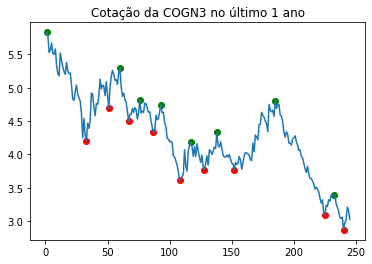

In [104]:
plt.title("Cotação da COGN3 no último 1 ano")
plt.scatter(df_max.index, df_max['min'], c='r')
plt.scatter(df_max.index, df_max['max'], c='g')
plt.plot(df_max.index, df_max['COGN3.SA'])
plt.show()

In [105]:
df_max = pd.DataFrame(df_close['BRPR3.SA'])
df_max.reset_index(drop=True, inplace=True)
n = 10
df_max['min'] = df_max.iloc[argrelextrema(df_max['BRPR3.SA'].values, np.less_equal,
                    order=n)[0]]['BRPR3.SA']
df_max['max'] = df_max.iloc[argrelextrema(df_max['BRPR3.SA'].values, np.greater_equal,
                    order=n)[0]]['BRPR3.SA']

# a = argrelextrema(df_close['COGN3.SA'].values, np.less_equal, order=n)[0]
# a

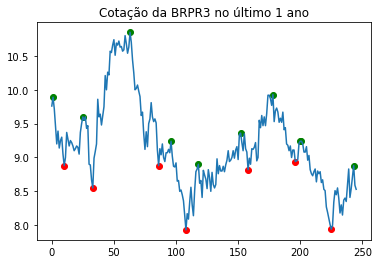

In [106]:
plt.title("Cotação da BRPR3 no último 1 ano")
plt.scatter(df_max.index, df_max['min'], c='r')
plt.scatter(df_max.index, df_max['max'], c='g')
plt.plot(df_max.index, df_max['BRPR3.SA'])
plt.show()

In [107]:
df_max['max'].dropna()

1       9.89
25      9.60
63     10.85
96      9.24
118     8.90
152     9.36
178     9.93
200     9.24
201     9.24
243     8.88
Name: max, dtype: float64

In [108]:
picos = {}
mins = {}
maxs = {}

for column in list(df_close.columns):
    mins[column] = (len(argrelextrema(df_close[column].values, np.less_equal, order=n)[0]))
    maxs[column] = (len(argrelextrema(df_close[column].values, np.greater_equal, order=n)[0]))

In [109]:
df_list = [(selic, 'Selic'), (prefixado, 'Prefixado'), (ipca, 'IPCA'), (hash11, 'HASH11.SA'), (tgar11, 'TGAR11.SA'),
           (biau39, 'BIAU39.SA'), (gold11, 'GOLD11.SA'), (xina11, 'XINA11.SA')]

for df in df_list:
    mins[df[1]] = (len(argrelextrema(df[0]['Último'].values, np.less_equal, order=n)[0]))
    maxs[df[1]] = (len(argrelextrema(df[0]['Último'].values, np.greater_equal, order=n)[0]))

In [110]:
keys = mins
# alpha = np.nextafter(np.float32(0), np.float32(1))
model = Model()
x = model.continuous_var_dict(keys, name='invs')
model.maximize(model.sum(x[i] * maxs[i] for i in keys))

In [111]:
model.add_constraints(x[i] >= 0.01 for i in keys)
model.add_constraints(x[i] <= 0.15 for i in keys)
model.add_constraint(model.sum(x[i] for i in keys) == 1)

docplex.mp.LinearConstraint[](invs_ALSO3.SA+invs_ALUP11.SA+invs_AURA33.SA+invs_BABA34.SA+invs_BOVA11.SA+invs_BRML3.SA+invs_BRPR3.SA+invs_COGN3.SA+invs_CSAN3.SA+invs_CYRE3.SA+invs_DIRR3.SA+invs_EGIE3.SA+invs_FESA4.SA+invs_GGBR4.SA+invs_GOAU4.SA+invs_IVVB11.SA+invs_JHSF3.SA+invs_KNRI11.SA+invs_MXRF11.SA+invs_OIBR3.SA+invs_RAIZ4.SA+invs_SULA11.SA+invs_TAEE11.SA+invs_TEND3.SA+invs_TRIS3.SA+invs_TRPL4.SA+invs_VIVT3.SA+invs_XPCI11.SA+invs_Selic+invs_Prefixado+invs_IPCA+invs_HASH11.SA+invs_TGAR11.SA+invs_BIAU39.SA+invs_GOLD11.SA+invs_XINA11.SA,EQ,1)

In [112]:
solution = model.solve(log_output=True)

Version identifier: 20.1.0.0 | 2020-11-10 | 9bedb6d68
CPXPARAM_Read_DataCheck                          1
CPXPARAM_RandomSeed                              202001241
Tried aggregator 1 time.
LP Presolve eliminated 72 rows and 33 columns.
Reduced LP has 1 rows, 3 columns, and 3 nonzeros.
Presolve time = 0.00 sec. (0.03 ticks)
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =            10.160000


In [113]:
model.print_solution()

objective: 10.160
  invs_ALSO3.SA=0.010
  invs_ALUP11.SA=0.010
  invs_AURA33.SA=0.010
  invs_BABA34.SA=0.010
  invs_BOVA11.SA=0.010
  invs_BRML3.SA=0.010
  invs_BRPR3.SA=0.010
  invs_COGN3.SA=0.010
  invs_CSAN3.SA=0.010
  invs_CYRE3.SA=0.150
  invs_DIRR3.SA=0.150
  invs_EGIE3.SA=0.010
  invs_FESA4.SA=0.010
  invs_GGBR4.SA=0.010
  invs_GOAU4.SA=0.010
  invs_IVVB11.SA=0.010
  invs_JHSF3.SA=0.090
  invs_KNRI11.SA=0.010
  invs_MXRF11.SA=0.150
  invs_OIBR3.SA=0.010
  invs_RAIZ4.SA=0.010
  invs_SULA11.SA=0.010
  invs_TAEE11.SA=0.010
  invs_TEND3.SA=0.150
  invs_TRIS3.SA=0.010
  invs_TRPL4.SA=0.010
  invs_VIVT3.SA=0.010
  invs_XPCI11.SA=0.010
  invs_Selic=0.010
  invs_Prefixado=0.010
  invs_IPCA=0.010
  invs_HASH11.SA=0.010
  invs_TGAR11.SA=0.010
  invs_BIAU39.SA=0.010
  invs_GOLD11.SA=0.010
  invs_XINA11.SA=0.010


In [114]:
total_return = 0
for i in keys:
    total_return += x[i].solution_value * return_dict[i]

In [115]:
total_var = 0
for i in keys:
    total_var += x[i].solution_value * var_dict[i]

In [116]:
total_rf = 0
for i in rf:
    total_rf += x[i].solution_value

In [117]:
total_a = 0
for i in a:
    total_a += x[i].solution_value

In [118]:
print('Valor encontrado pela função objetivo: ', model.objective_value)
print('Retorno total: ', total_return)
print('Variância total: ', total_var)
print('Total alocado em renda fixa: ', total_rf)
print('Total alocado em renda variável: ', total_a)

Valor encontrado pela função objetivo:  10.16
Retorno total:  -6.7716
Variância total:  91.42235286137463
Total alocado em renda fixa:  0.03
Total alocado em renda variável:  0.97


## 3. Conclusão

#### Em 2.2.1. Modelo mantendo todas as restrições solicitadas pelo investidor
Neste modelo nós mantivemos as retrições solicitadas pelo investidor, acrescentando nas restrições o investimento em certas ações que são do seu interesse.

##### Objetivo - Minimizar Variância
* Variâcia encontrada pela função objetivo:  55.01854056755589
* Retorno total:  7.999999999999997
* Total alocado em renda fixa:  0.15
* Total alocado em renda variável:  0.8500000000000001

##### Objetivo - Maximizar Retorno
* Retorno encontrado pela função objetivo:  8.255755501530928
* Variância total:  60.00
* Total alocado em renda fixa:  0.15
* Total alocado em renda variável:  0.85

##### Análise dos resultados

| Objetivo  | Variância  |  Retorno |   |    |
|---|---|---|---|---|
|  Minimizar variância |  **55.01** | 7.99  |   |   |
| Maximizar retorno  |  60.00 | **8.25**  |   |   |

#### 2.2.2 Modelo removendo algumas restrições entre ativos de renda variável
Neste modelo foram removidas algumas restrições impostas pelo investidor como o investimento em ativos específicos da carteira de acordo com o seu interesse.

##### Objetivo - Minimizar Variância
* Variâcia encontrada pela função objetivo:  49.18879023082532
* Retorno total:  7.999999999999998
* Total alocado em renda fixa:  0.15
* Total alocado em renda variável:  0.85

##### Objetivo - Maximizar Retorno
* Retorno encontrado pela função objetivo:  9.7309305094014
* Variância total:  59.99999999999999
* Total alocado em renda fixa:  0.15
* Total alocado em renda variável:  0.85

##### Análise de Resultados:

| Objetivo  | Variância  |  Retorno |   |    |
|---|---|---|---|---|
|  Minimizar variância |  **49.18** | 7.99 |   |   |
| Maximizar retorno  |  59.99 | **9.73**  |   |   |

Percebemos uma diminuição da variância final encontrada pelo modelo. Também notou-se aumento do retorno total como objetivo. Isso pode ocorrer pois, no modelo anterior, ao restringir ativos específicos, o investidor pode estar sujeito a erros e escolher ativos que no final possuem, nesse caso, alta variância e possivelmente menores retornos. 

#### 2.2.3 Modelo removendo algumas restrições e utilizando faixas de restrições

##### Objetivo - Minimizar Variância
* Variâcia encontrada pela função objetivo:  48.51314952015901
* Retorno total:  7.999999999999998
* Total alocado em renda fixa:  0.1
* Total alocado em renda variável:  0.8999999999999999

##### Objetivo - Maximizar Retorno
* Retorno encontrado pela função objetivo:  10.471671559498496
* Variância total:  60.00
* Total alocado em renda fixa:  0.1
* Total alocado em renda variável:  0.8999999999999999

##### Análise de Resultados - Ao retirar o investimento de ativos específicos e ao utilizarmos faixas de restrições:

| Objetivo  | Variância  |  Retorno |   |    |
|---|---|---|---|---|
|  Minimizar variância |  **48.51** | 7.99 |   |   |
| Maximizar retorno  |  60.00 | **10.47**  |   |   |

Podemos ver uma leve diminuição na variância total, assim como aumento do retorno. Isso aconteceu devido à possibilidade que a faixa de restrições deu ao modelo de alocar até 90% do investimento em rendas variáveis e menor alocamento em rendas fixas que podem não ser a melhor opção para investimento seguindo esses objetivos.

#### 2.2.4 Modelo mais livre

##### Objetivo - Minimizar Variância
* Variâcia encontrada pela função objetivo:  47.70984227946272
* Retorno total:  7.999999999999998
* Total alocado em renda fixa:  0.015
* Total alocado em renda variável:  0.985

##### Objetivo - Maximizar Retorno
* Retorno encontrado pela função objetivo:  11.602893818642055
* Variância total:  59.99999999999999
* Total alocado em renda fixa:  0.015
* Total alocado em renda variável:  0.9849999999999999

##### Análise de Resultados - Modelo mais livre:

| Objetivo  | Variância  |  Retorno |   |    |
|---|---|---|---|---|
|  Minimizar variância |  **47.70** | 7.99 |   |   |
| Maximizar retorno  |  59.99 | **11.60**  |   |   |

Ao retirarmos as retrições para investimento o modelo conseguiu encontrar os melhores resultados dentre todos os já apresentados. Pois, ao eliminar a restrição de ativos específicos e de grupos de ativos na obrigatoriedade da carteira, foi apresentado para nós os melhores investimentos no decorrer de 1 ano.

A variância mínima encontrada para a carteira de 47%
E retorno máximo encontrado de 11.6%

Com isso podemos observar o poder que o modelo tem de escolher os melhores ativos por conta própria. E, além disso, observamos como os interesses particulares dos investidores podem afetar bastante o resultado final de acordo com certas restrições impostas.

Sendo assim, uma boa opção deixar o modelo mais liberto e alimentá-lo com dados variados para posterior análise!